# Impedence (Z) Analysis
### Prerequisite
You must have a working local installation of Ansys.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

### Create the design in Metal
Set up a design of a given dimension. Dimensions will be respected in the design rendering. <br>
Note that the design will be centered in the origin, will thus equally extend in all quadrants.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'
hfss = design.renderers.hfss

gui = MetalGUI(design)

Create a single transmon with one readout resonator. It will show in the center of the previously defined chip.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options =  dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()

### Connect to Ansys
Open a new Ansys window (wait for it to open before you execute any other cell). <br>
Skip this cell if you already have it open

In [4]:
hfss.open_ansys()

After Ansys opens, connect to it and add a driven modal design called SingleTransmon. The design will appear in the active project.

In [5]:
hfss.connect_ansys()
hfss.add_drivenmodal_design("SingleTransmon")

INFO 01:31PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:31PM [load_ansys_project]: 	Opened Ansys App
INFO 01:31PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:31PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 01:31PM [connect_design]: No active design found (or error getting active design).
INFO 01:31PM [connect]: 	 Connected to project "Project16". No design detected
INFO 01:31PM [connect_design]: 	Opened active design
	Design:    SingleTransmon [Solution type: DrivenModal]
WARNING 01:31PM [connect_setup]: 	No design setup detected.
WARNING 01:31PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 01:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


### Setup Ansys to run the Analysis on the SingleTransmon design
Here, pin Q1_a is converted into a lumped port with an impedance of 70 Ohms. <br>
Meanwhile, the central junction Q1_rect_jj is rendered as both a port and an inductor with an impedance of 50 Ohms and an inductance of 10 nH, respectively.

Here for reference the list of arguments to renderer_design():
* First parameter: List of components to render (empty list if rendering whole Metal design)
* Second parameter: List of pins (qcomp, pin) with open endcaps
* Third parameter: List of pins (qcomp, pin, impedance) to render as lumped ports
* Fourth parameter: List of junctions (qcomp, elt, impedance, draw_ind) to render as lumped ports
* Fifth parameter: List of junctions (qcomp, elt) to omit altogether during rendering
* Sixth parameter: Whether to render chip via box plus buffer or fixed chip size

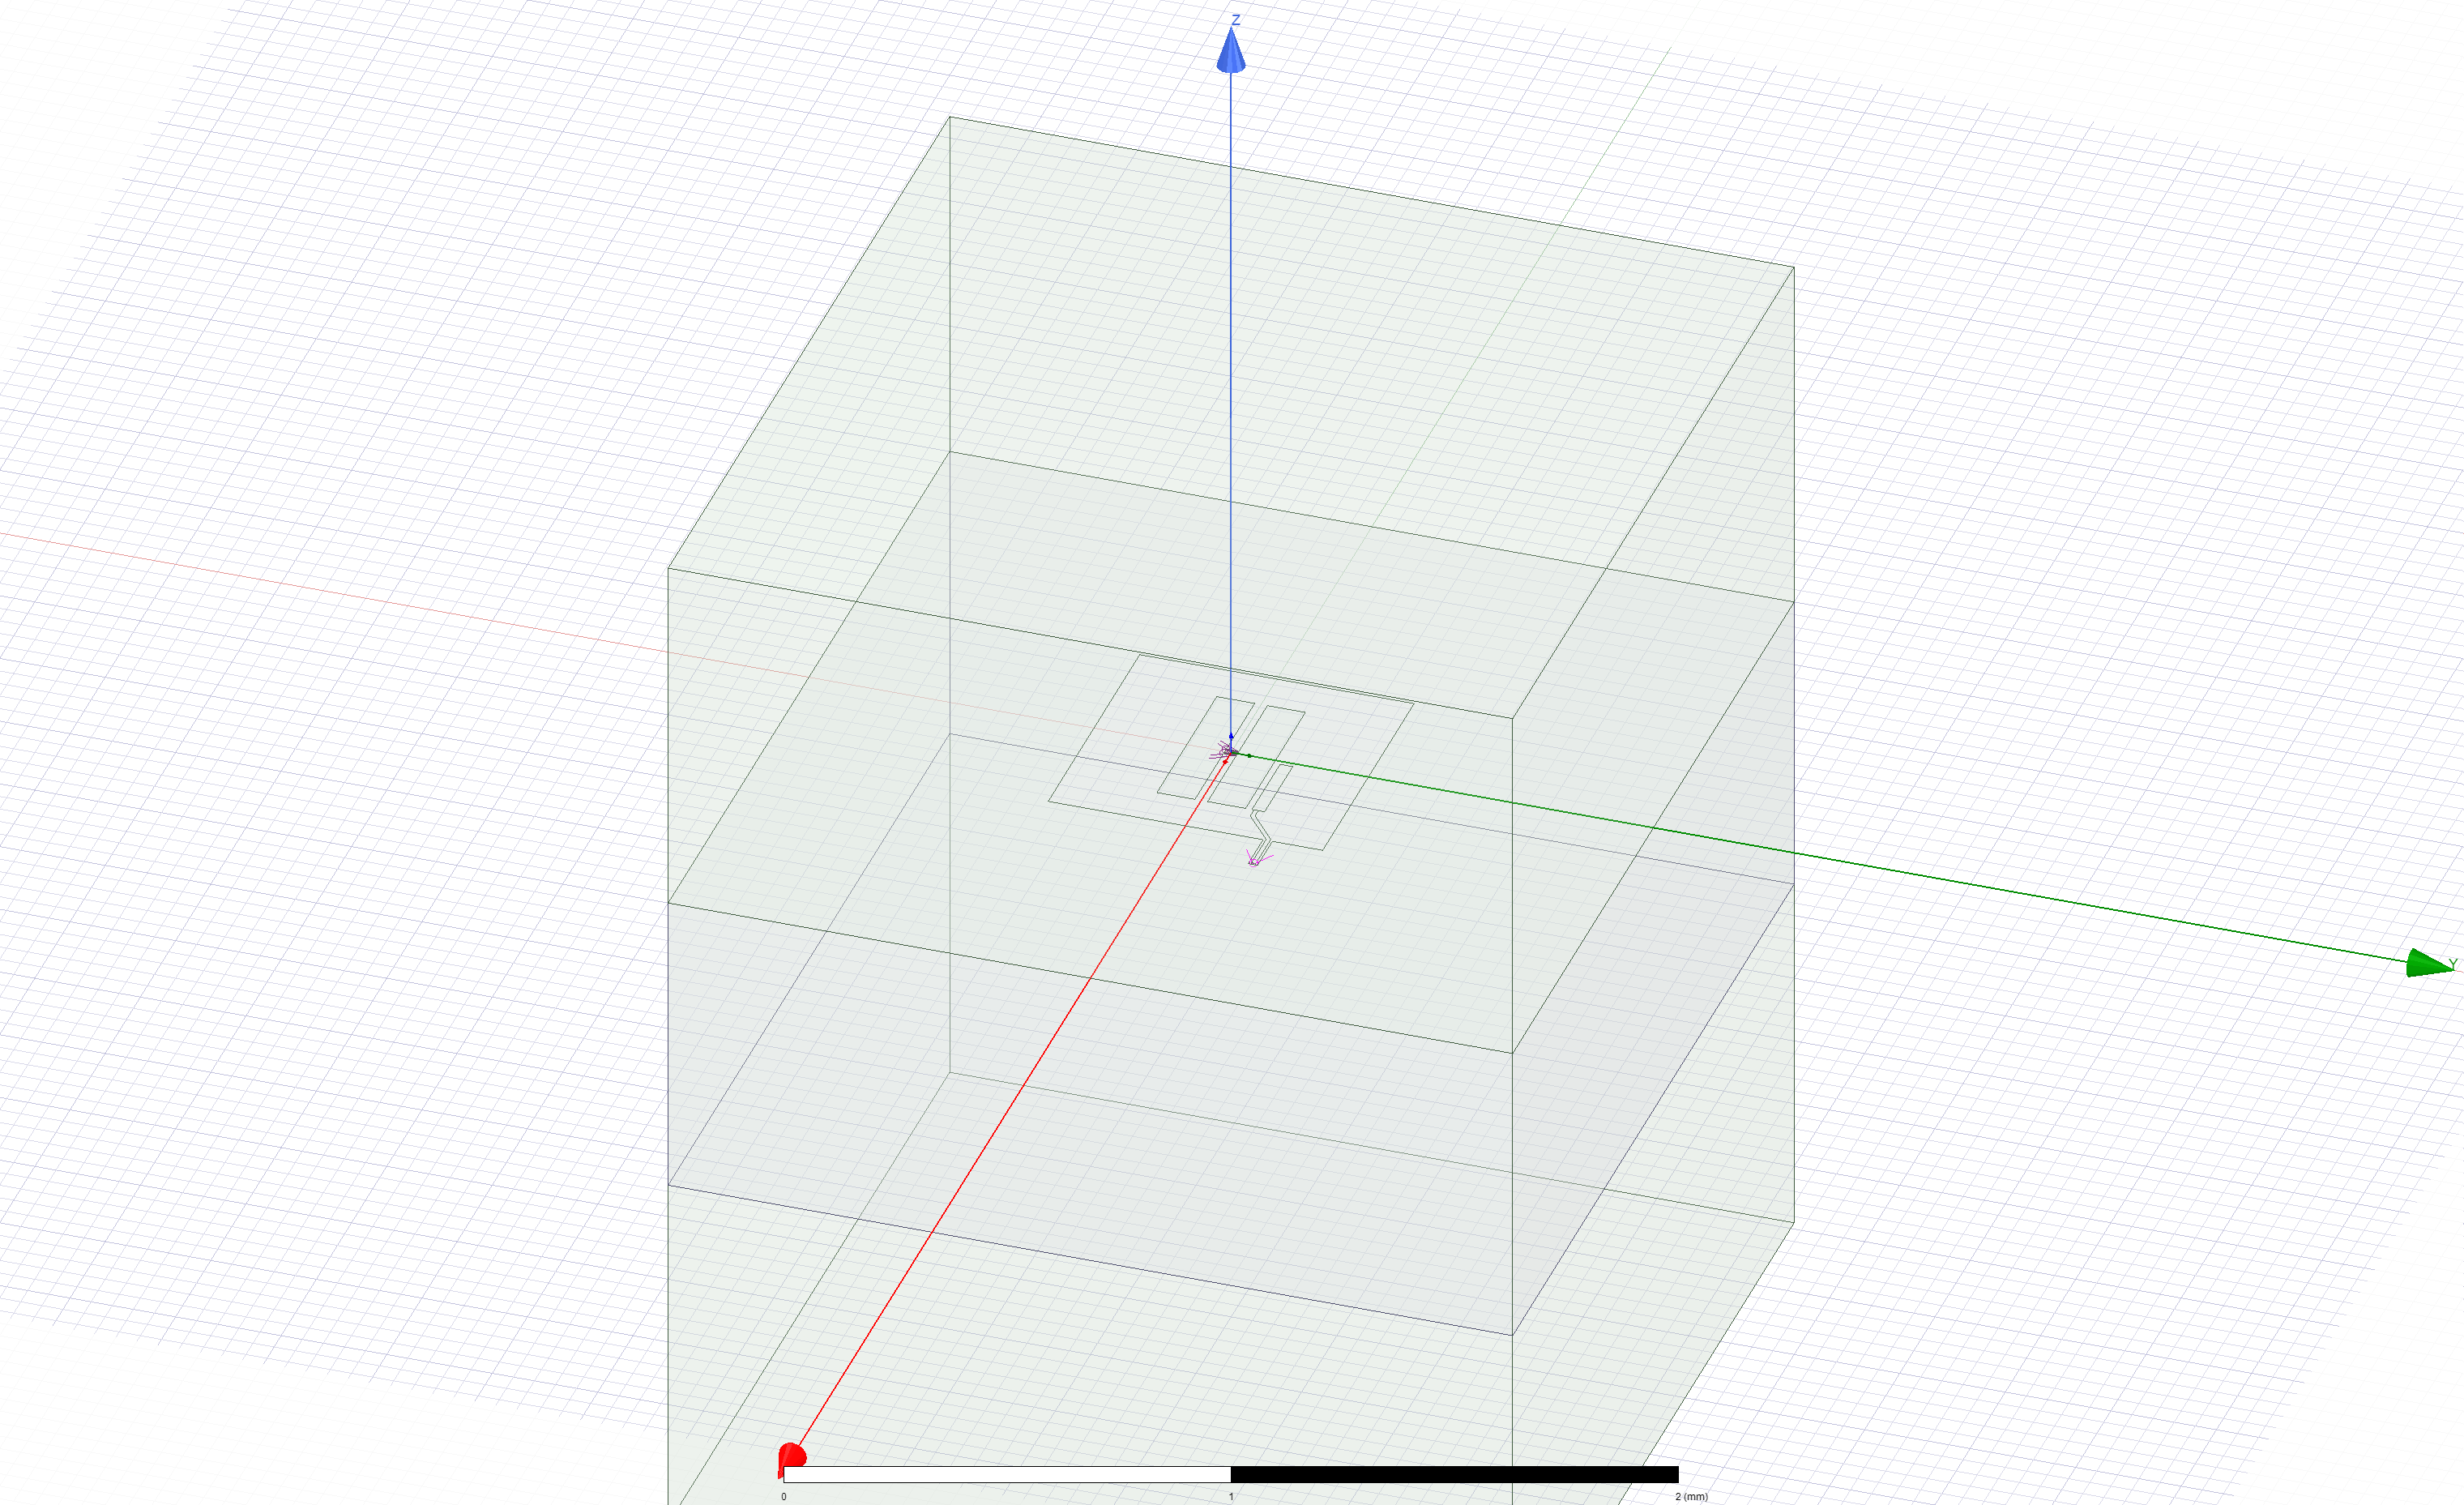

In [6]:
hfss.render_design([], [], [('Q1', 'readout', 70)], [('Q1', 'rect_jj', 50, True)], [], box_plus_buffer=False)
hfss.save_screenshot()

Add a new driven modal simulation setup called NewSetup to the SingleTransmon design.

Here for reference all the customizable parameters and their default values in add_drivenmodal_setup():
* freq_ghz=5 (simulation frequency)
* name="Setup" (setup name)
* max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
* max_passes=10 (maximum number of passes)
* min_passes=1 (minimum number of passes)
* min_converged=1 (minimum number of converged passes)
* pct_refinement=30 (percent refinement)
* basis_order=1 (basis order)

In [7]:
hfss.add_drivenmodal_setup(name="NewSetup", max_passes=30)

Verify that the currently active project, design, and setup names are correct.

In [8]:
print(f"""
project_name = {hfss.pinfo.project_name}
design_name  = {hfss.pinfo.design_name}
setup_name   = {hfss.pinfo.setup_name}
""")


project_name = Project16
design_name  = SingleTransmon
setup_name   = Setup



Next, add a frequency sweep called NewSweep to the NewSetup setup.

Here for reference all the customizable parameters and their default values in add_sweep():
* setup_name="Setup" (name of setup)
* start_ghz=2.0 (starting frequency)
* stop_ghz=8.0 (stopping frequency)
* count=101 (total number of frequencies)
* step_ghz=None (frequency step size)
* name="Sweep" (name of sweep)
* type="Fast" (type of sweep)
* save_fields=False (whether or not to save fields)

In [9]:
hfss.add_sweep(setup_name="NewSetup", name="NewSweep", stop_ghz=13)

INFO 01:32PM [get_setup]: 	Opened setup `NewSetup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


### Execute the analysis and plot the results

In [10]:
hfss.analyze_sweep('NewSweep', 'NewSetup')

INFO 01:32PM [get_setup]: 	Opened setup `NewSetup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 01:32PM [analyze]: Analyzing setup NewSetup : NewSweep


Plot the various parameters

In [11]:
hfss.plot_params(['Z11', 'Z21']);

In [12]:
hfss.plot_params(['Y11', 'Y21']);

In [13]:
hfss.plot_params(['S11', 'S21', 'S22']);

Finally, disconnect from Ansys

In [14]:
hfss.disconnect_ansys()